# Multiclass classification with GPflow

In [1]:
import GPflow
import tensorflow as tf
import matplotlib
import numpy as np
matplotlib.style.use('ggplot')
%matplotlib inline
plt = matplotlib.pyplot

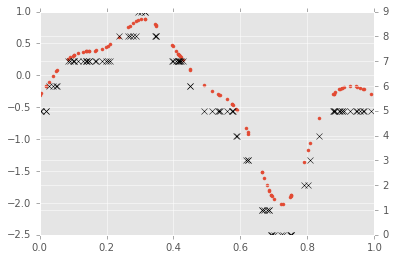

In [2]:
#make a one dimensional ordinal regression problem
np.random.seed(1)
X = np.random.rand(100,1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100,1))

plt.plot(X, f, '.')
Y = np.round((f + f.min())*3)
Y = Y - Y.min()
Y = np.asarray(Y, np.int32)
plt.twinx()
plt.plot(X, Y, 'kx')

In [3]:
bin_edges = np.arange(np.unique(Y).size)
bin_edges = bin_edges - bin_edges.mean()
m = GPflow.svgp.SVGP(X, Y, 
                     kern=GPflow.kernels.Matern32(1) + GPflow.kernels.White(1, variance=0.01),
                     likelihood=GPflow.likelihoods.Ordinal(bin_edges),
                     Z=X[::5].copy(), whiten=True, q_diag=True)

In [4]:
m.kern.white.variance.fixed = True
m.Z.fixed = True
m.likelihood.num_gauss_hermite_points = 4
_ = m.optimize()


compiling tensorflow function...
done
optimization terminated, setting model state


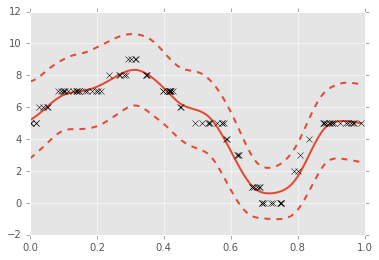

In [5]:
def plot(m):
    plt.figure()
    Xtest = np.linspace(m.X.value.min(), m.X.value.max(), 100).reshape(-1, 1)
    mu, var = m.predict_y(Xtest)
    line, = plt.plot(Xtest, mu, lw=2)
    col=line.get_color()
    plt.plot(Xtest, mu+2*np.sqrt(var), '--', lw=2, color=col)
    plt.plot(Xtest, mu-2*np.sqrt(var), '--', lw=2, color=col)
    plt.plot(m.X.value, m.Y.value, 'kx')
plot(m)

In [ ]:
m._kill_autoflow()

In [8]:
print m.likelihood.sigma

sigma transform:+ve prior:None
[ 1.]


In [29]:
print m.compute_log_likelihood()

-128.33176924


In [26]:
m.sorted_params

In [28]:
m.sigma = 1./30000

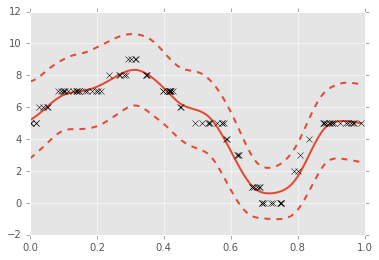

In [15]:
m.